In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers import Rescaling

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils import plot_model


In [3]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=42dc7f7e8c4abbe53e00ab4cb063d44d5d32ca1de050c41386543dfdb944b986
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


In [4]:
!pip install git+https://github.com/jfilter/split-folders.git

  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-ozziz6yb
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-ozziz6yb
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for split_folders: filename=split_folders-0.5.1-py3-none-any.whl size=8401 sha256=c95a8d121641fe32e95eec3dd480a10e3c841f4cf66dfa604b8390fced57c35c
  Stored in directory: /tmp/pip-ephem-wheel-cache-rokgz2xs/wheels/0c/da/06/fcebe493adfe604ee9a1d4511e3932a6e63a044edb7a10dec8
Successfully built split_folders


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 224
HEIGHT = 224
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = "/content/drive/MyDrive/data"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')



In [7]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

In [8]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))


MildDemented 8960 images
ModerateDemented 6464 images
NonDemented 9600 images
VeryMildDemented 8960 images


In [9]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape
# fie path / categoryID / catLable



(33984, 3)

In [10]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']


In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=4)

In [12]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [13]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(27187, 3)
(6797, 3)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )

validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/content/drive/MyDrive/data/train'
validation_dir = '/content/drive/MyDrive/data/val'
# test_dir = '/kaggle/working/Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(128, 128),
#         shuffle=True,
#         seed = SEED,
#         batch_size =64,
#         class_mode ='categorical')

epochs = 50

Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [15]:
train_generator_resnet = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')
train_generator_inception = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator_resnet =  validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')
validation_generator_inception =  validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

Found 33984 images belonging to 4 classes.
Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [38]:
def combined_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)
        batch2 = next(generator2)
        yield [batch1[0], batch2[0]], batch1[1]  # Combine the input batches and keep the labels the same

train_generator_fused = combined_generator(train_generator_resnet, train_generator_inception)
validation_generator_fused = combined_generator(validation_generator_resnet, validation_generator_inception)

In [39]:
class_names = list(train_generator.class_indices.keys())
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

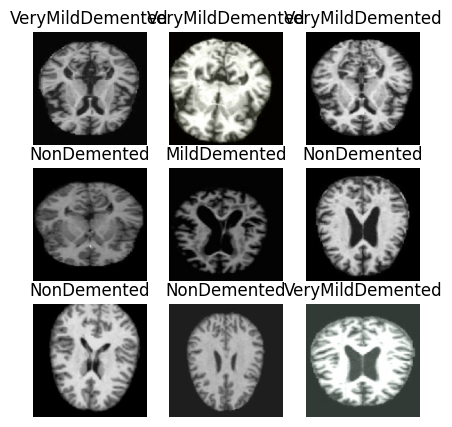

In [40]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

In [46]:
base_model_2 = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
base_model_2.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model2 = tf.keras.Sequential([base_model_2, global_average_layer,
  keras.layers.BatchNormalization(),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])

In [11]:
train_dir = '/content/drive/MyDrive/data/train'
validation_dir = '/content/drive/MyDrive/data/val'


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values
    rotation_range=20,         # Randomly rotate images
    width_shift_range=0.2,     # Randomly translate images
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True       # Randomly flip images horizontally
)

# Preprocessing for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [16]:
SEED = 42
BATCH_SIZE = 64

train_generator_resnet = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),    # Resize images to match model input
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

train_generator_inception = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

validation_generator_resnet = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

validation_generator_inception = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)


Found 33984 images belonging to 4 classes.
Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [18]:
from tensorflow.keras.applications import InceptionV3

# Load pre-trained Inception model without the top layer
base_inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
inception_model = Model(inputs=base_inception_model.input, outputs=base_inception_model.output)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model

# Load pre-trained ResNet model without the top layer
base_resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_model = Model(inputs=base_resnet_model.input, outputs=base_resnet_model.output)



In [19]:
feature_model_resnet = tf.keras.models.Model(
    inputs=resnet_model.input,
    outputs=GlobalAveragePooling2D()(resnet_model.output)
)

feature_model_inception = tf.keras.models.Model(
    inputs=inception_model.input,
    outputs=GlobalAveragePooling2D()(inception_model.output)
)


In [7]:
resnet_model.summary()
inception_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import os

# Set your directories
train_dir = '/content/drive/MyDrive/data/train'
validation_dir = '/content/drive/MyDrive/data/val'

# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
SEED = 42

# Initialize the ResNet50 model pre-trained on ImageNet, exclude the top classification layer
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Create a new model that outputs the features (before the final classification layer)
feature_model_resnet = Model(inputs=resnet_model.input, outputs=resnet_model.output)

# Preprocessing functions
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

# Function to extract features and save them
def extract_and_save_features(generator, feature_model, output_file):
    features = []
    labels = []
    for batch, (x_batch, y_batch) in enumerate(generator):
        print(f"Extracting features for batch {batch+1}/{len(generator)}")
        feature_batch = feature_model.predict(x_batch)  # Extract features from the batch
        features.append(feature_batch)
        labels.append(y_batch)

        if batch >= len(generator) - 1:
            break

    # Convert the features and labels to numpy arrays
    features = np.vstack(features)
    labels = np.vstack(labels)

    # Save the features and labels to a file
    np.savez(output_file, features=features, labels=labels)

# Extract features for training and validation sets
extract_and_save_features(train_generator, feature_model_resnet, '/content/drive/MyDrive/data/train_features_resnet.npz')
extract_and_save_features(validation_generator, feature_model_resnet, '/content/drive/MyDrive/data/validation_features_resnet.npz')

print("Feature extraction complete and saved.")


Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Extracting features for batch 1/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Extracting features for batch 2/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Extracting features for batch 3/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Extracting features for batch 4/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Extracting features for batch 5/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Extracting features for batch 6/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Extracting features for batch 7/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step
Extracting features for batch 8/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Extracting features for batch 9/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Extracting features for batch 10/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Extracting features for batch 11/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step
Extracting features for batch 12/531
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Extracting features for batch 13/531
2/2 ━━━━━━━

In [21]:
data = np.load('/content/drive/MyDrive/data/train_features_resnet.npz')


In [22]:
print(data.keys())


KeysView(NpzFile '/content/drive/MyDrive/data/train_features_resnet.npz' with keys: features, labels)


In [23]:
features = data['features']  # Replace 'features' with the actual key name
labels = data['labels']      # Replace 'labels' with the actual key name


In [24]:
print(features.shape)  # Check the dimensions of the features
print(labels.shape)    # Check the dimensions of the labels
print(features[:5])    # View the first 5 feature vectors
print(labels[:5])      # View the first 5 labels


(33984, 4, 4, 2048)
(33984, 4)
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.5540373e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.8632188e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.3182864e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.2222795e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.1565847e-03
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.0246379e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.5867281e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.8094516e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.7714841e+00
    0.0000000e+00 0.0000000e

In [29]:
data = np.load('/content/drive/MyDrive/data/validation_features_resnet.npz')

In [30]:
print(data.keys())



KeysView(NpzFile '/content/drive/MyDrive/data/validation_features_resnet.npz' with keys: features, labels)


In [31]:
features = data['features']  # Replace 'features' with the actual key name
labels = data['labels']      # Replace 'labels' with the actual key name

In [32]:
print(features.shape)  # Check the dimensions of the features
print(labels.shape)    # Check the dimensions of the labels
print(features[:5])    # View the first 5 feature vectors
print(labels[:5])      # View the first 5 labels


(6400, 4, 4, 2048)
(6400, 4)
[[[[0.         0.         0.         ... 2.4368017  0.
    0.        ]
   [0.         0.         0.         ... 1.4497168  0.
    0.        ]
   [0.         0.         0.         ... 1.729775   0.
    0.        ]
   [0.         0.         0.         ... 4.0434265  0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 2.6458647  0.
    0.        ]
   [0.         0.         0.         ... 2.113093   0.
    0.        ]
   [0.         0.         0.07811171 ... 1.4645481  0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.96766067 0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 1.969923   0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 1